# NODDI-Watson

*(Zhang et al. 2012)* proposed a model to estimate the dispersion of neurites (i.e. both axons and neuron dendrites), and is called Neurite Orientation Dispersion and Density Imaging (NODDI). It models dispersion for a single axon bundle using a Watson distribution $W(\kappa,\boldsymbol{\mu})$, that is a particular case of Bingham when $\kappa=\kappa_1=\kappa_2$. As such, it is incapable of modeling axon bending or fanning. The model separately models the CSF, restricted and hindered diffusion as a Gaussian Ball, Stick and Zeppelin model. NODDI models the signal as
\begin{align}
 E^{\textrm{NODDI}}_{\textrm{Watson}}= \underbrace{f_{\textrm{CSF}}\overbrace{E_{\textrm{iso}}(\cdot|\lambda_{\textrm{CSF}})}^{\textrm{Ball}}}_{\textrm{CSF}}
                             +\overbrace{W(\kappa,\boldsymbol{\mu})}^{\textrm{Watson}}\,*_{\mathbb{S}^2}\, \left[\underbrace{f_h\overbrace{E_{\textrm{h}}(\cdot|\lambda_\perp^{\textrm{tort}},\lambda_\parallel)}^{\textrm{Zeppelin}}}_{\textrm{Hindered Extra-Axonal}}+\underbrace{f_r\overbrace{E_r(\cdot|\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}\right].
\end{align}
To improve the stability of estimated model parameters, NODDI sets several constraints on model parameters: 
- isotropic diffusivity $\lambda_{\textrm{CSF}}$ is fixed to $3\cdot10^-9 m^2/s$ 
- parallel diffusivity $\lambda_\parallel$ of the stick and zeppelin are the same and fixed to $1.7\cdot10^-9 m^2/s$ 
- A tortuosity model is used to link the perpendicular diffusivity $\lambda_\perp^{\textrm{tort}}$ to the intra- and extra- axonal volume fraction $f_r$, $f_h$ and parallel diffusivity $\lambda_\parallel$.

The only parameters that NODDI-Watson finally fits to the data are Watson parameters $\kappa$, $\mu$ and the volume fractions $f_{\textrm{CSF}}$, $f_h$ and $f_r$.

# Using Dmipy to set up the NODDI-Watson model

Setting up the NODDI-Watson model in Dmipy is straight-forward.  
First, we instantiate the model components for the non-dispersed components themselves: a Ball for the CSF, and the Stick and Zeppelin for the intra- and extra-axonal diffusion.

In [1]:
from dmipy.signal_models import cylinder_models, gaussian_models
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()

We then Watson-disperse the stick and zeppelin together, making a representation for a dispersed single axon bundle

In [2]:
from dmipy.distributions.distribute_models import SD1WatsonDistributed
watson_dispersed_bundle = SD1WatsonDistributed(models=[stick, zeppelin])

Then, we can set part of NODDI's model parameter links that we listed above. The bundle representation allows to set tortuous, equal and fixed parameters. First, we show the parameter names of the bundle.

In [3]:
watson_dispersed_bundle.parameter_names

['G2Zeppelin_1_lambda_perp',
 'SD1Watson_1_odi',
 'G2Zeppelin_1_lambda_par',
 'SD1Watson_1_mu',
 'C1Stick_1_lambda_par',
 'partial_volume_0']

We can then set the tortuous $\lambda_\perp$ parameter, followed by the equal $\lambda_\parallel$ parameters of the stick and zeppelin, and finally we set the remaining $\lambda_\parallel$ to $1.7\times10^{-9}m^2/s$. Note that fixing or linking a parameter removes it permanently from the parameter list, meaning it cannot be used for subsequent parameter links. For this reason, we needed to do the tortuosity constraint before fixing $\lambda_\parallel$.

In [4]:
watson_dispersed_bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
watson_dispersed_bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
watson_dispersed_bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)

Finally, we put the model together with the scheme as follows.

In [5]:
from dmipy.core.modeling_framework import MultiCompartmentModel
NODDI_mod = MultiCompartmentModel(models=[ball, watson_dispersed_bundle])

You can see the names and cardinality of the to-be optimized parameters in the generated MultiCompartmentModel as follows.

In [6]:
NODDI_mod.parameter_names

['G1Ball_1_lambda_iso',
 'SD1WatsonDistributed_1_SD1Watson_1_mu',
 'SD1WatsonDistributed_1_partial_volume_0',
 'SD1WatsonDistributed_1_SD1Watson_1_odi',
 'partial_volume_0',
 'partial_volume_1']

The last thing is to fix the diffusivity of the Ball compartment to static values. We can do that using the model.set_fixed_parameter(parameter_name, value) function.

In [7]:
NODDI_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

We can visualize the model as follows:

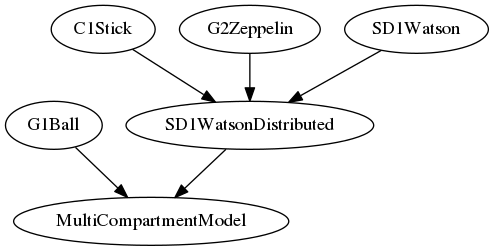

In [8]:
from IPython.display import Image
NODDI_mod.visualize_model_setup(view=False, cleanup=False)
Image('Model Setup.png')

# Fitting NODDI to Human Connectome Project data

To illustrate Dmipy's ease-of-use we also fit the our constructed model to a coronal slice of the HCP data. We will illustrate FODs in the red region of interest later.

In [9]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


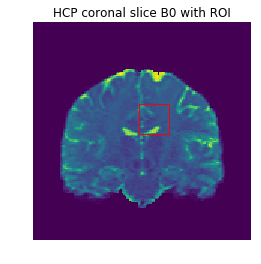

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

## Fit NODDI to HCP data
Having pathos and numba installed, fitting the model to this coronal slice takes less than 10 minutes.

In [11]:
NODDI_fit_hcp = NODDI_mod.fit(
    scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 4.23309421539 seconds
Fitting of 8181 voxels complete in 647.025583029 seconds.
Average of 0.0790888134738 seconds per voxel.


## Visualize results

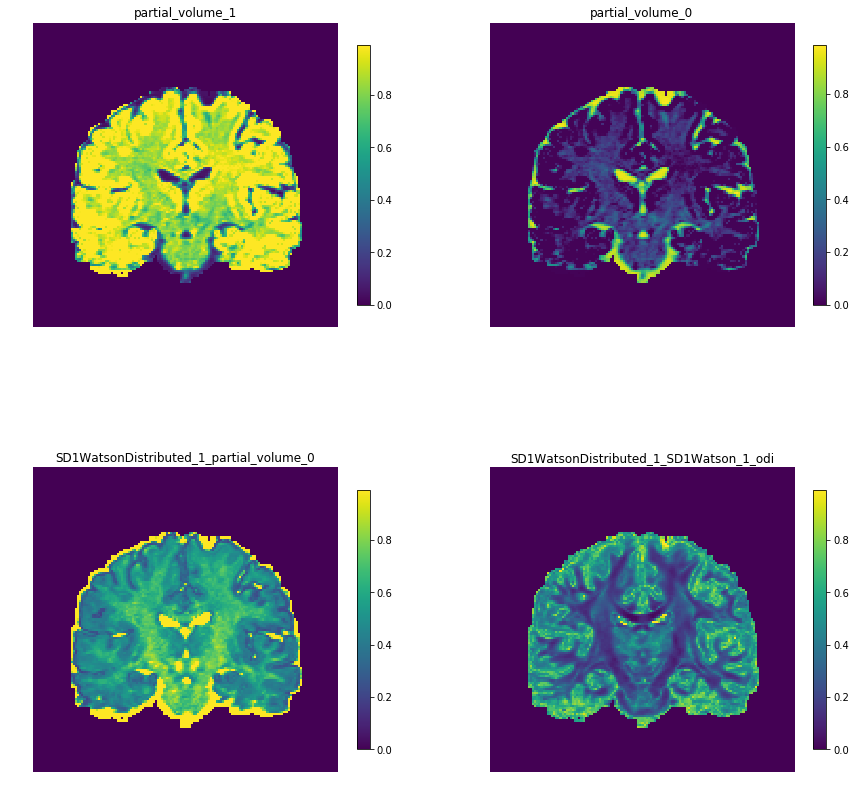

In [12]:
fitted_parameters = NODDI_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[15, 15])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_axis_off()
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.7)
    counter += 1

Above we see the familiar maps. Remember that partial_volume_0/1/2 represent fractions of models in the order they were given to the MultiCompartmentMicrostructureModel object. In this case, 0 represents the fraction of Ball (CSF), and the 1 represents the Stick (intra-axonal) and 2 represents the zeppelin (extra-axonal).

In the bottom-right ODI map you can see that the concentration is highest in the corpus callosum and in coherent white matter bundles. Finally, the $\lambda_\parallel$ and $\lambda_{\textrm{iso}}$ maps are fixed to the values we gave them.

## Estimating Fiber Orientation Distributions (FODs)

We estimate FODs on the right side of the corpus callosum and use the estimated concentration ODI as background.

In [13]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724')
# The next line produces the FOD sphere functions.
# The lower bound option artificially puts a lower bound on the ODI so they don't get too sharp.
# It does not affect the fitted_parameters themselves.
fods = NODDI_fit_hcp.fod(sphere.vertices, visual_odi_lower_bound=0.08)

In [14]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

odi_res = fitted_parameters['SD1WatsonDistributed_1_SD1Watson_1_odi']
odi_im = slicer(odi_res[70:90,0, 70:90, None], interpolation='nearest', affine=affine, opacity=0.7)

/user/rfick/home/anaconda2/lib/python2.7/site-packages/vtk/util/numpy_support.py:134: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [15]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, odi_im)
fvtk.record(ren=ren, size=[700, 700])

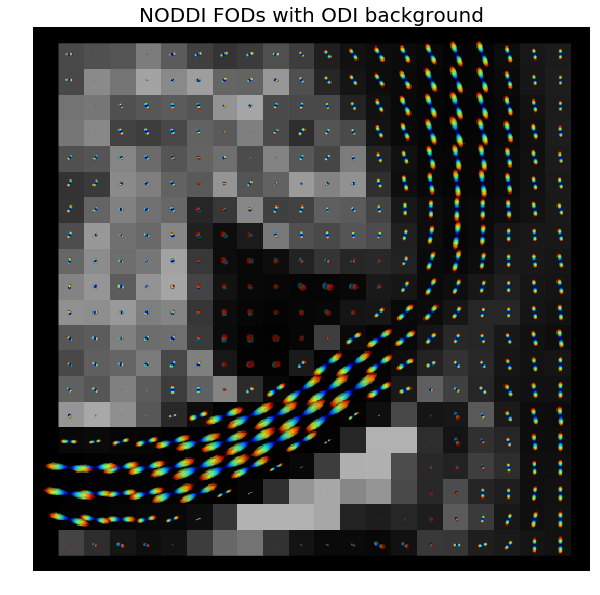

In [16]:
import matplotlib.image as mpimg
img = mpimg.imread('dipy.png')

plt.figure(figsize=[10, 10])
plt.imshow(img[100:-97, 100:-85])
plt.title('NODDI FODs with ODI background', fontsize=20)
plt.axis('off');

You can see the corpus callosum coming in the from the left and joining the centrum semiovale on the right. The intensity of the background shows ODI of the Watson distribution (inversely related to concentration $\kappa$). Notice it is low in the corpus callosum and higher in non-white matter areas. Notice that NODDI-Watson cannot estimate crossings, which are expected in the centrum semiovale on the right. This biases any comparison/estimation of volume fractions and concentrations in these areas.

In [17]:
from os import remove
remove('dipy.png')

## Estimating Error Metrics: MSE and $R^2$

Whenever you fit a model, it's always wise to check out the error of the model fit. Here we estimate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination. In MSE the lower is better, while $R^2$ has an upper bound of one, which represents a perfect model fit.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/fitted_modeling_framework.py:211: RuntimeWarning: invalid value encountered in divide
/user/rfick/home/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/fitted_modeling_framework.py:198: RuntimeWarning: invalid value encountered in divide


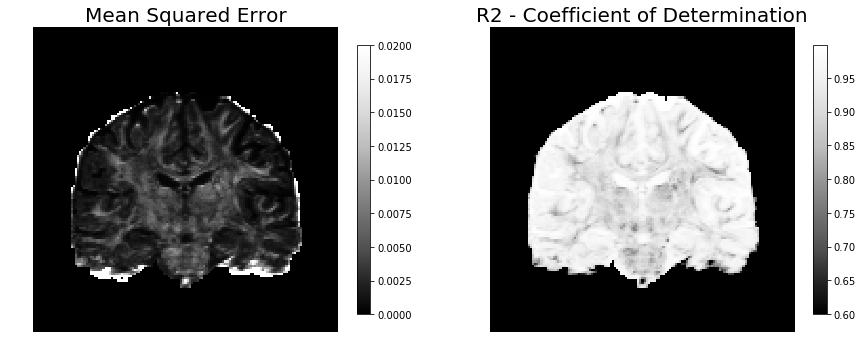

In [18]:
mse = NODDI_fit_hcp.mean_squared_error(data_hcp)
R2 = NODDI_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=0.02, cmap='Greys_r')
axs[0].set_axis_off()
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=0.6, cmap='Greys_r')
axs[1].set_axis_off()
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);

Ideally, you want the MSE and $R^2$ to show no structure of the underlying data - which would mean the model can at least fit the data equally well everywhere. Instead, in NODDI-Watson we can see clearly see the structure of the different brain areas. This means that the model cannot fit the diffusion signal equally well in all brainn areas, and that interpretation of model parameters will be biased when comparing them between these different areas.

When doing these studies, ALWAYS verify whether differences in estimated parameters reflect actual tissue changes, or only reflect the limitations of the model itself.

## References
- Zhang, Hui, et al. "NODDI: practical in vivo neurite orientation dispersion and density imaging of the human brain." Neuroimage 61.4 (2012): 1000-1016.